In [1]:
import pandas as pd
from pandas import HDFStore

import numpy as np
from numpy import array
import h5py

/anaconda3/envs/bio/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:


import tensorflow as tf
from sklearn.metrics import roc_auc_score

# Fix random seeds
from numpy.random import seed
seed(1)

from tensorflow import set_random_seed
set_random_seed(2)

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14800892217529853017
]


In [4]:
from utils import read_big_pickle

# file is larger than 2GB, use pickle to read in by chunks
file_paths = ["data/sequence_train.pkl", "data/sequence_val.pkl", "data/sequence_test.pkl"]

genes_train = read_big_pickle(file_paths[0])
genes_val = read_big_pickle(file_paths[1])
genes_test = read_big_pickle(file_paths[2])
        

# Load train and val inputs

In [5]:
input_train = np.stack(genes_train["seq"], axis=0)
input_train.shape

(36390, 2000, 4)

In [6]:
input_val = np.stack(genes_val["seq"], axis=0)
input_val.shape

(2599, 2000, 4)

# Load train and val exprs

In [7]:
cell_types = genes_train.columns.values.astype(str)[:57]


In [8]:
output_trains = pd.DataFrame()
output_vals = pd.DataFrame()
output_tests = pd.DataFrame()

for cell_type in cell_types:
    output_trains[cell_type] = np.array(genes_train[cell_type])
    output_vals[cell_type] = np.array(genes_val[cell_type])
    output_tests[cell_type] = np.array(genes_test[cell_type])


In [9]:
import pickle

experiment_tag = "MT"

In [53]:

from models import build_sequential_model, ModelMGPU
from keras.callbacks import ModelCheckpoint



for cell_type in cell_types:
    model = build_sequential_model()
    parallel_model = ModelMGPU(model, gpus = 2)
    parallel_model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', metrics=['mae'])
    
    
    # saves the model weights after each epoch if the validation loss decreased
    checkpointer = ModelCheckpoint(filepath=("models/experiments_" + experiment_tag + "_" + cell_type + ".hdf5"), verbose=1, save_best_only=True)
    
    history = []    
    history.append(
        parallel_model.fit(input_train, output_trains[cell_type], validation_data=(input_val, output_vals[cell_type]), initial_epoch=0 ,epochs=30, batch_size=256, shuffle=True, callbacks=[checkpointer]))
    
    histories_to_store = []
    for h in history:
        histories.append(h.history)

    with open("models/history_" + experiment_tag + "_" + cell_type + ".pkl", 'wb') as f_out:
        pickle.dump(histories ,f_out)
    
    del parallel_model
    del model


ValueError: For multi-gpu usage to be effective, call `multi_gpu_model` with `gpus >= 2`. Received: `gpus=0`

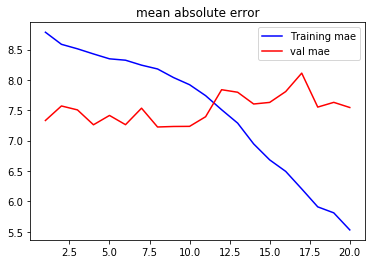

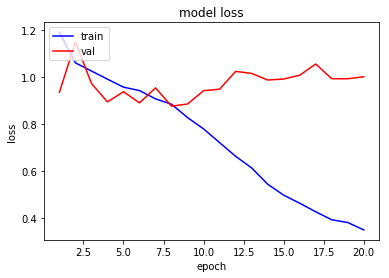

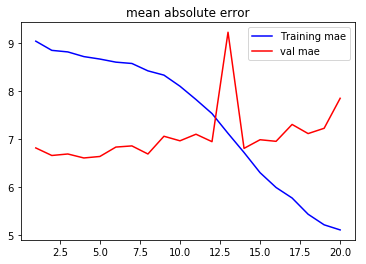

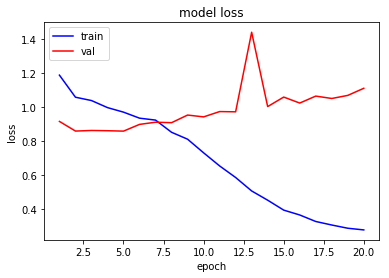

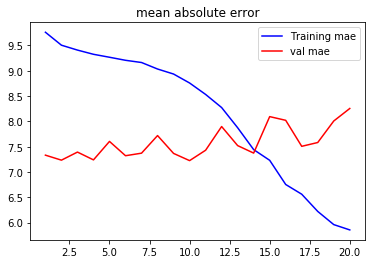

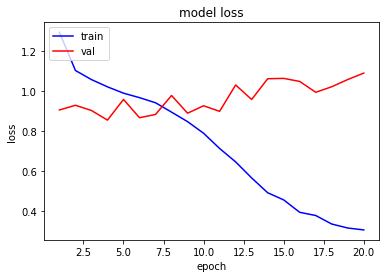

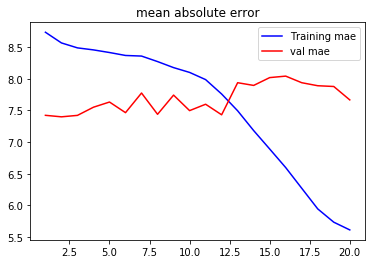

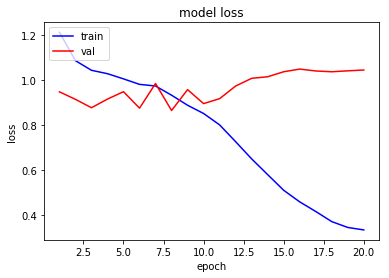

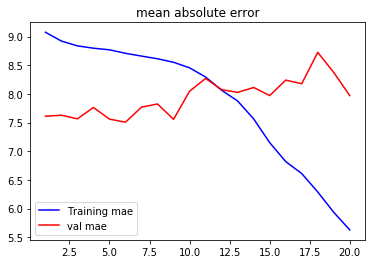

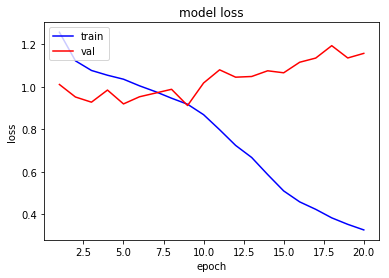

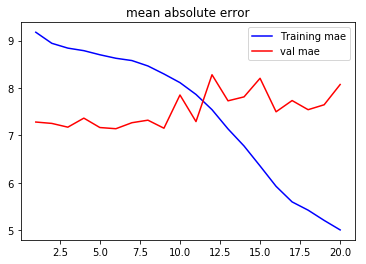

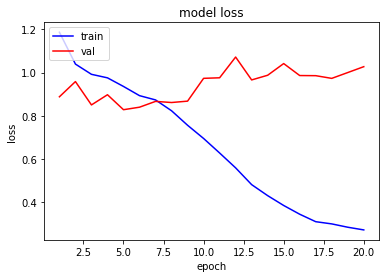

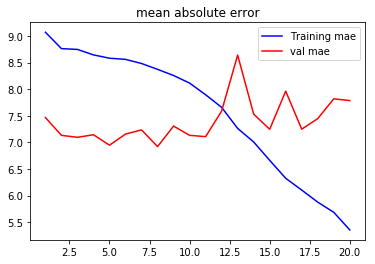

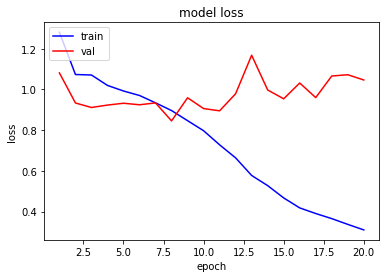

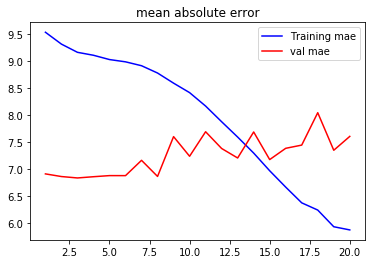

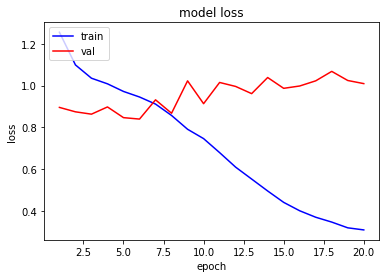

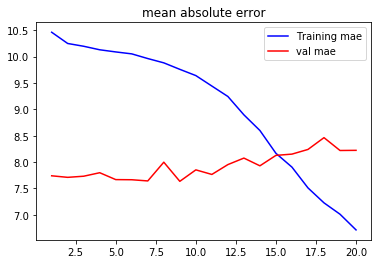

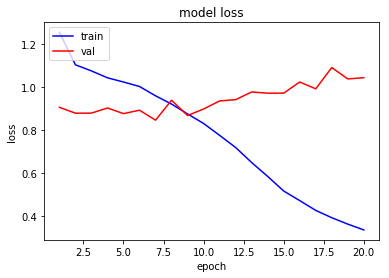

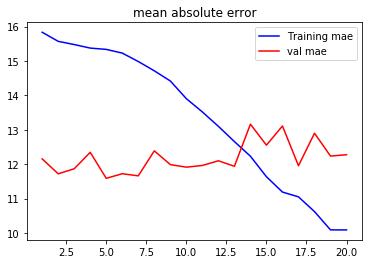

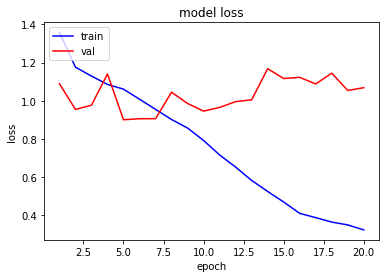

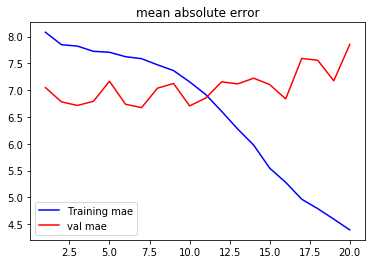

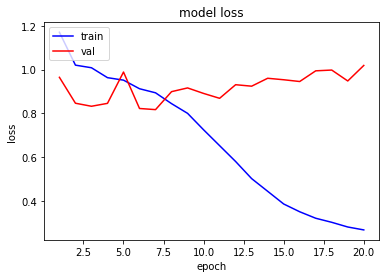

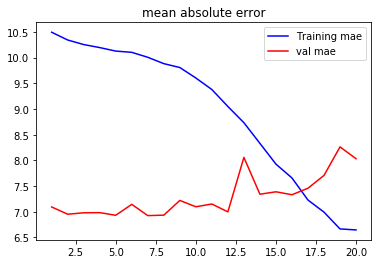

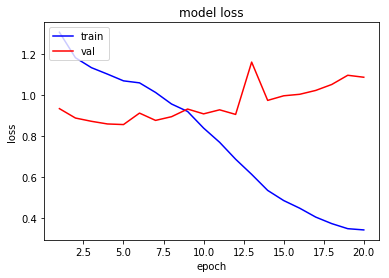

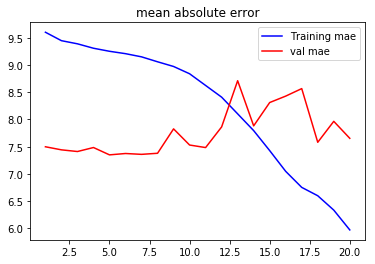

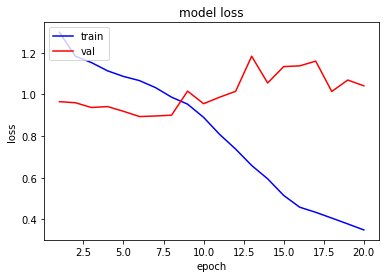

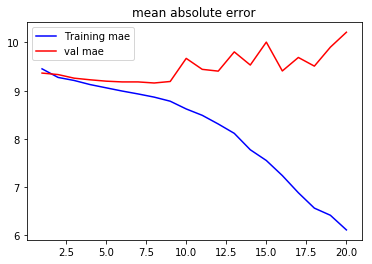

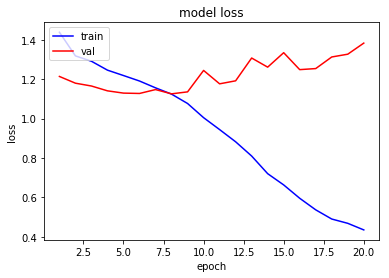

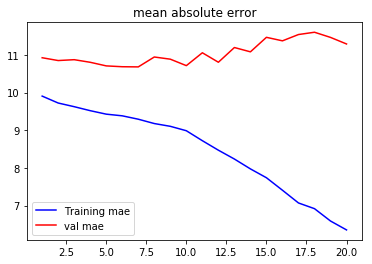

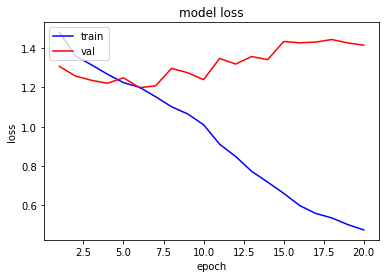

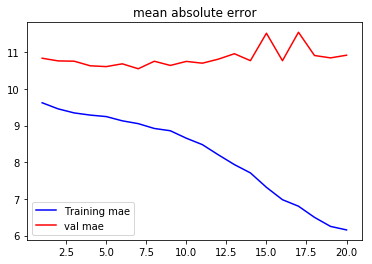

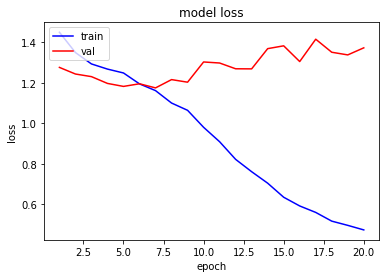

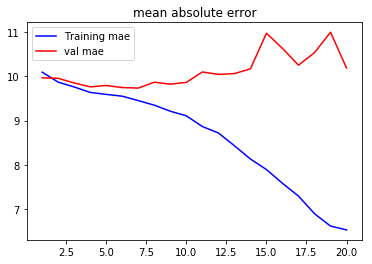

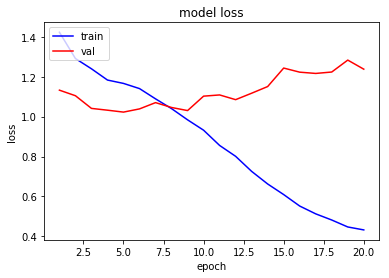

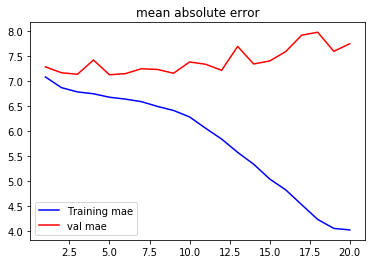

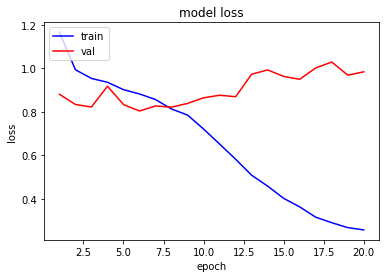

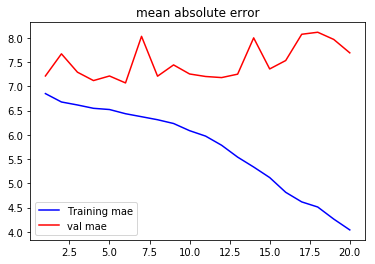

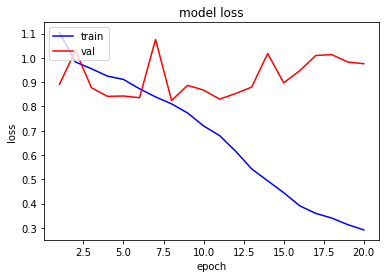

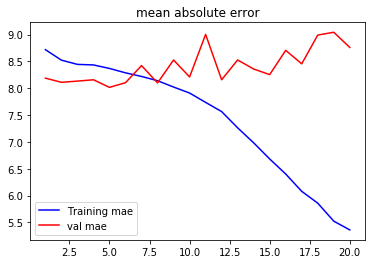

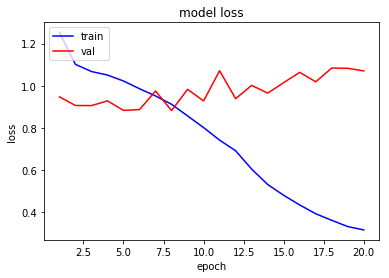

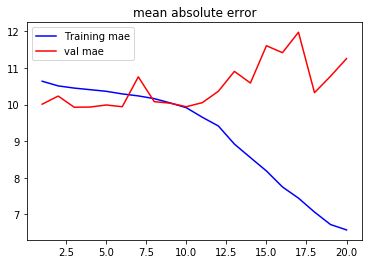

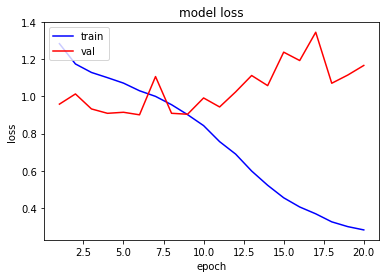

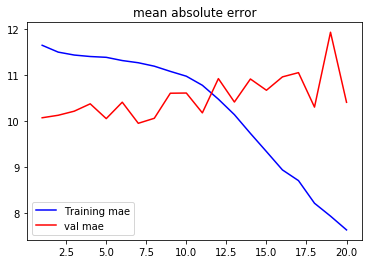

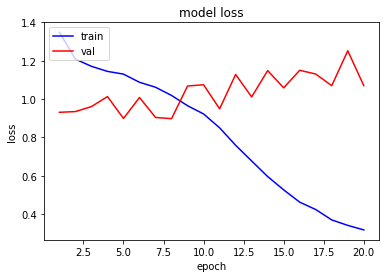

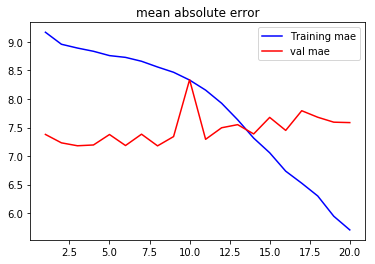

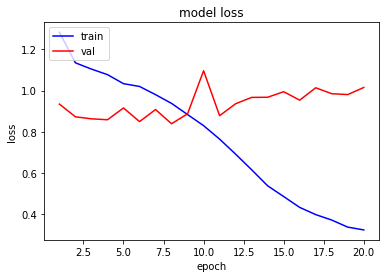

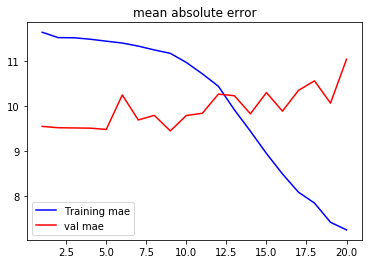

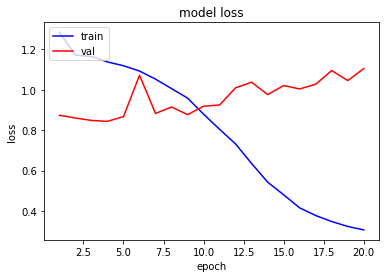

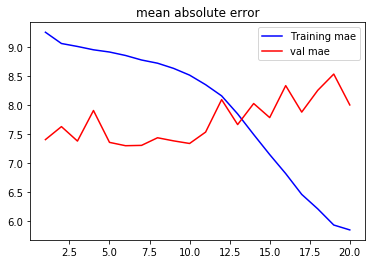

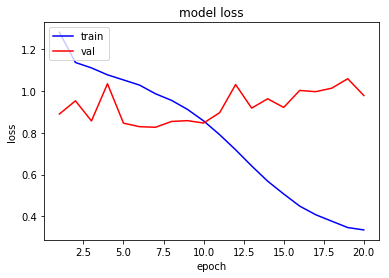

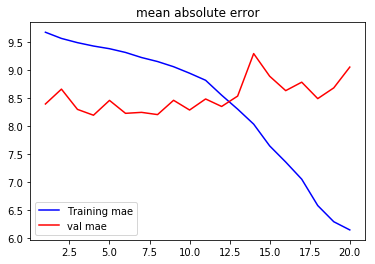

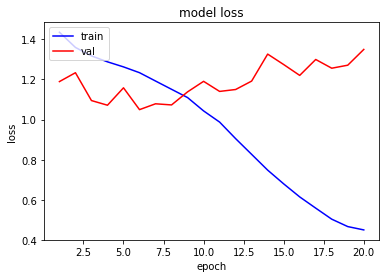

In [15]:
from visualization import plot_train_histories

for cell_type in cell_types[:26]:
    with open("models/history_" + experiment_tag + "_" + cell_type + ".pkl", 'rb') as f_in:
        h = pickle.load(f_in)

        # plot traning history  
        plot_train_histories(h)

In [17]:
input_test = np.stack(genes_test["seq"], axis=0)
input_test.shape

(3449, 2000, 4)

## Model prediction


**Pearson Correlation**

In [42]:
from keras.models import load_model
from scipy import stats
from visualization import line_pred_vs_expr, scatter_pred_vs_expr

output_tests = pd.DataFrame()

preds = pd.DataFrame()
exprs = pd.DataFrame()

for cell_type in cell_types[:2]:
#     output_tests[cell_type] = np.array(genes_test[cell_type])
    
    best_model = load_model("models/experiments_"  + experiment_tag + "_" + cell_type + ".hdf5")

    preds[cell_type] = best_model.predict(input_test)
    exprs[cell_type] = output_tests[cell_type]

    pred_log = np.log(preds[cell_type]+1)
    expr_log = np.log(exprs[cell_type]+1)
    
    
    
    line_pred_vs_expr(pred_log, expr_log)
    
    scatter_pred_vs_expr(pred_log, expr_log)
    
    
    
    pearson_coef, p_value = stats.pearsonr(pred_log, expr_log.reshape((3449,1)))
    print(experiment_tag, cell_type)
    print("pearson coef = " , pearson_coef)
    print("p value = ", p_value)



/anaconda3/envs/bio/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


NameError: name 'input_test' is not defined

**Random results based on means and standard deviation**

pearson coef =  -0.01027588797511337
p value =  0.5463214724028294


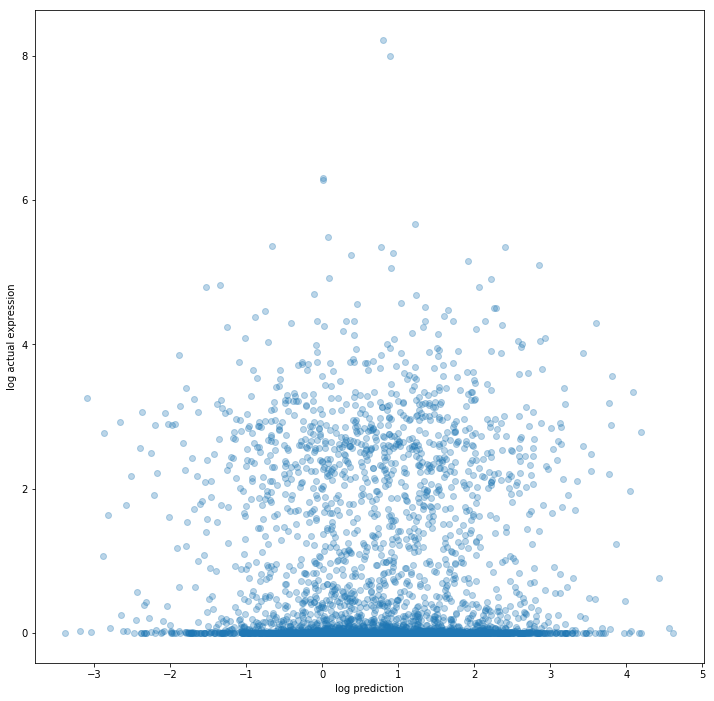

In [103]:
random_results = np.random.normal(exp_log.mean(), exp_log.std(), 3449)

pearson_coef, p_value = stats.pearsonr(random_results, exp_log)
print("pearson coef = " , pearson_coef)
print("p value = ", p_value)

scatter_pred_vs_expr(random_results, expr_log)


In [104]:
np.corrcoef(random_results, expr_log.reshape((3449,1)), rowvar=False)[0,1]

-0.010275887975113362

**Random shuffle of expressions**

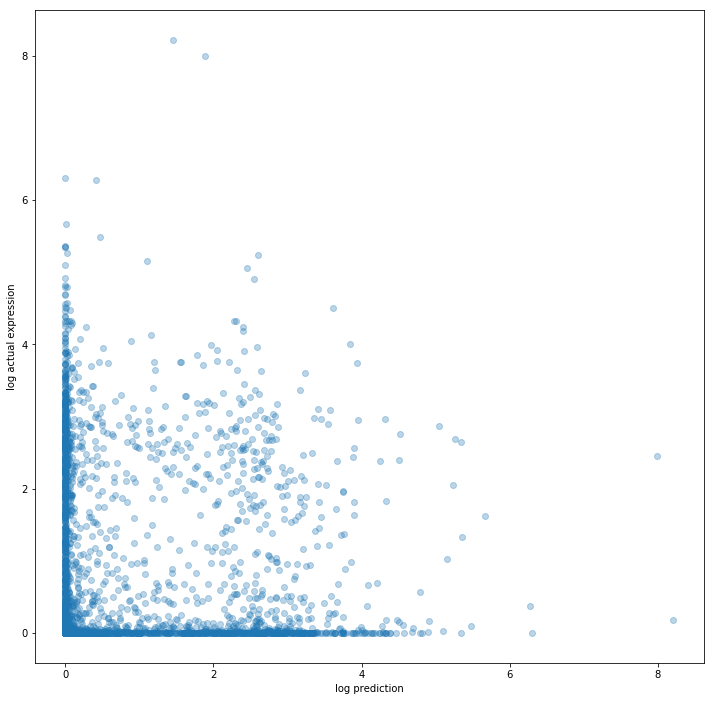

In [105]:
from sklearn.utils import shuffle

expr_shuffled = shuffle(expr_log)
scatter_pred_vs_exp(expr_shuffled, expr_log)

In [106]:
pearson_coef, p_value = stats.pearsonr(exp_shuffled.reshape(3449,1), exp_log.reshape((3449,1)))
print("pearson coef = " , pearson_coef)
print("p value = ", p_value)

pearson coef =  [-0.00445647]
p value =  [0.79360929]


In [10]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Dropout, Flatten


def build_model():
    """
    11 layers
    - 8 Conv
    - 3 Dense
    
    """
    
    inputs = Input(shape=(2000,4,), name="input")
    
    x = Conv1D(filters=64, kernel_size=10, activation="relu", name="Conv1")(inputs)
    x = Conv1D(filters=64, kernel_size=10, activation="relu", name="Conv2")(x)
    x = MaxPooling1D(pool_size=5)(x)
#     x = Dropout(0.5)(x)

    x = Conv1D(filters=128, kernel_size=10, activation="relu", name="Conv3")(x)
    x = Conv1D(filters=128, kernel_size=10, activation="relu", name="Conv4")(x)
    x = MaxPooling1D(pool_size=3)(x)
    x = Dropout(0.5)(x)
    
    x = Conv1D(filters=256, kernel_size=10, activation="relu", name="Conv5")(x)
    x = Conv1D(filters=256, kernel_size=10, activation="relu", name="Conv6")(x)
    x = MaxPooling1D(pool_size=3)(x)
    x = Dropout(0.5)(x)
    
    x = Conv1D(filters=128, kernel_size=10, activation="relu", name="Conv7")(x)
    x = Conv1D(filters=128, kernel_size=10, activation="relu", name="Conv8")(x)
    x = MaxPooling1D(pool_size=3)(x)
    x = Dropout(0.5)(x)
    
    x = Flatten(name="Flatten1")(x)
    x = Dense(625, activation="relu", name="Dense1")(x)
    x = Dense(625, activation="relu", name="Dense2")(x)
    x = Dense(125, activation="relu", name="Dense3")(x)
    
    pred = Dense(1, activation="linear", name="pred")(x)
    pred_bin = Dense(1, activation="sigmoid", name="pred_bin")(x)
    
    model = Model(input=inputs, output=[pred, pred_bin])
    return model

Using TensorFlow backend.


In [11]:
model = build_model()
model.summary()
model.compile(loss={'pred':'mean_squared_logarithmic_error', 'pred_bin':'binary_crossentropy'}, optimizer='adam', metrics=['mae'])

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 2000, 4)      0                                            
__________________________________________________________________________________________________
Conv1 (Conv1D)                  (None, 1991, 64)     2624        input[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv1D)                  (None, 1982, 64)     41024       Conv1[0][0]                      
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 396, 64)      0           Conv2[0][0]                      
__________________________

/anaconda3/envs/bio/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [12]:
all_exprs = pd.concat([output_trains, output_vals, output_tests])
median = all_exprs["E003"].median()


output_bin_trains = pd.DataFrame()
output_bin_trains["E003"] = (output_trains["E003"] > median).apply(lambda x: 1 if x else 0)

output_bin_vals = pd.DataFrame()
output_bin_vals["E003"] = (output_vals["E003"] > median).apply(lambda x: 1 if x else 0)

output_bin_tests = pd.DataFrame()
output_bin_tests["E003"] = (output_tests["E003"] > median).apply(lambda x: 1 if x else 0)

In [13]:
hist = model.fit(input_train, y=[output_trains["E003"], output_bin_trains["E003"]], validation_data=(input_val, [output_vals["E003"], output_bin_vals["E003"]]), initial_epoch=0 ,epochs=5, batch_size=1024, shuffle=True)




Train on 36390 samples, validate on 2599 samples
Epoch 1/5
36390/36390 [==============================] - 1431s 39ms/step - loss: 2.3071 - pred_loss: 1.6043 - pred_bin_loss: 0.7028 - pred_mean_absolute_error: 9.6716 - pred_bin_mean_absolute_error: 0.4530 - val_loss: 1.5962 - val_pred_loss: 0.9807 - val_pred_bin_loss: 0.6155 - val_pred_mean_absolute_error: 6.7961 - val_pred_bin_mean_absolute_error: 0.4454
Epoch 2/5
36390/36390 [==============================] - 1446s 40ms/step - loss: 1.7051 - pred_loss: 1.1534 - pred_bin_loss: 0.5517 - pred_mean_absolute_error: 9.0046 - pred_bin_mean_absolute_error: 0.3879 - val_loss: 1.5604 - val_pred_loss: 0.9775 - val_pred_bin_loss: 0.5829 - val_pred_mean_absolute_error: 6.7791 - val_pred_bin_mean_absolute_error: 0.4305
Epoch 3/5
18432/36390 [==============>...............] - ETA: 11:33 - loss: 1.6548 - pred_loss: 1.1374 - pred_bin_loss: 0.5174 - pred_mean_absolute_error: 8.9932 - pred_bin_mean_absolute_error: 0.3631

KeyboardInterrupt: 